In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [11]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2015-01-01 ', 'jobs_archive_2015-01-02 ', 'jobs_archive_2015-01-03 ', 'jobs_archive_2015-01-04 ', 'jobs_archive_2015-01-05 ', 'jobs_archive_2015-01-06 ', 'jobs_archive_2015-01-09 ', 'jobs_archive_2015-01-10 ', 'jobs_archive_2015-01-11 ', 'jobs_archive_2015-01-12 ', 'jobs_archive_2015-01-13 ', 'jobs_archive_2015-01-14 ', 'jobs_archive_2015-01-15 ', 'jobs_archive_2015-01-16 ', 'jobs_archive_2015-01-17 ', 'jobs_archive_2015-01-18 ', 'jobs_archive_2015-01-19 ', 'jobs_archive_2015-01-20 ', 'jobs_archive_2015-01-21 ', 'jobs_archive_2015-01-22 ', 'jobs_archive_2015-01-23 ', 'jobs_archive_2015-01-24 ', 'jobs_archive_2015-01-25 ', 'jobs_archive_2015-01-26 ', 'jobs_archive_2015-01-27 ', 'jobs_archive_2015-01-28 ', 'jobs_archive_2015-01-29 ', 'jobs_archive_2015-01-30 ', 'jobs_archive_2015-01-31 ', 'jobs_archive_2015-02-01 ', 'jobs_archive_2015-02-02 ', 'jobs_archive_2015-02-03 ', 'jobs_archive_2015-02-04 ', 'jobs_archive_2015-02-05 ', 'jobs_archive_2015-02-06 ', 'jobs_archive_2015-

In [12]:
def time_filter(indices, last_days=1):
    if last_days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

In [13]:
ind = time_filter(indices, 7)
ind = ','.join(ind)
print(ind)

jobs_archive_2016-06-08,jobs_archive_2016-06-09,jobs_archive_2016-06-10,jobs_archive_2016-06-11,jobs_archive_2016-06-12,jobs_archive_2016-06-13,jobs_archive_2016-06-14


In [14]:
q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:recon"

In [15]:
myquery = {
  "size": 0,
  "aggs": {
    "2": {
      "terms": {
        "field": "jobstatus", "size": 5,
        "order": { "_count": "desc" }
      },
      "aggs": {
        "3": { "avg": { "field": "wall_time"  }   },
        "4": { "avg": { "field": "nevents"  } },
        "5": { "avg": { "field": "cpuconsumptiontime"  }  },
        "6": { "avg": { "field": "corecount" }  },
        "7": { "avg": { "field": "inputfilebytes" }  },
        "8": { "sum": { "field": "inputfilebytes" }  }
      }
    }
  },
  "query": {
    "filtered": {
      "query": {  "query_string": { "analyze_wildcard": True, "lowercase_expanded_terms": False,  "query": q }  }
    }
  }
}


In [18]:
myquery = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "NOT produsername:gangarbt AND jobname:*",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "processingtype": {
                    "query": "recon",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "jobstatus": {
                    "query": "finished",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "query_string": {
                  "query": "jobname:*",
                  "analyze_wildcard": True,
                  "lowercase_expanded_terms": False
                }
              }
            },
            {
              "range": {
                "modificationtime": {
                  "gte": 1465301538041,
                  "lte": 1465906338041,
                  "format": "epoch_millis"
                }
              }
            }
          ]
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "histogram": {
        "script": "(doc['nevents'].value) ? doc['wall_time'].value*10/doc['nevents'].value : 0",
        "lang": "expression",
        "interval": 5
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "atlasrelease",
            "size": 10
          }
        }
      }
    }
  }
}

In [19]:
res = es.search(index=ind, body=myquery, request_timeout=600)

In [20]:
print(res)

{'took': 50, 'hits': {'max_score': 0.0, 'hits': [], 'total': 12500}, 'timed_out': False, 'aggregations': {'2': {'buckets': [{'3': {'buckets': [{'score': 51.64380376094126, 'key': 'Atlas-20.11.0', 'doc_count': 4817, 'bg_count': 41694}], 'doc_count': 4824}, 'key': 0, 'doc_count': 4824}, {'3': {'buckets': [], 'doc_count': 0}, 'key': 5, 'doc_count': 0}, {'3': {'buckets': [{'score': 45.17905518594745, 'key': 'Atlas-20.1.5', 'doc_count': 20, 'bg_count': 20893}], 'doc_count': 20}, 'key': 10, 'doc_count': 20}, {'3': {'buckets': [{'score': 35.01816214416514, 'key': 'Atlas-20.1.5', 'doc_count': 97, 'bg_count': 60070}], 'doc_count': 97}, 'key': 15, 'doc_count': 97}, {'3': {'buckets': [{'score': 35.058068431833696, 'key': 'Atlas-20.1.5', 'doc_count': 98, 'bg_count': 65905}], 'doc_count': 98}, 'key': 20, 'doc_count': 98}, {'3': {'buckets': [{'score': 35.06639433097124, 'key': 'Atlas-20.1.5', 'doc_count': 47, 'bg_count': 59975}], 'doc_count': 47}, 'key': 25, 'doc_count': 47}, {'3': {'buckets': [{'sc

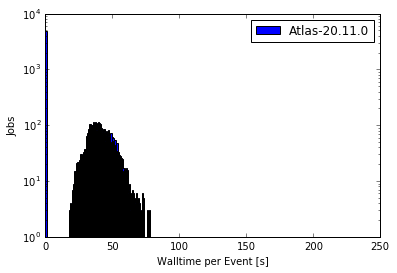

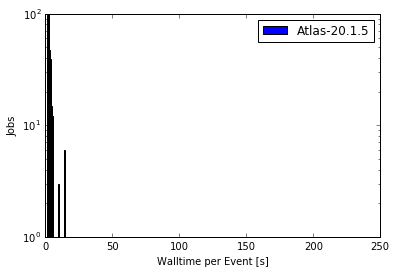

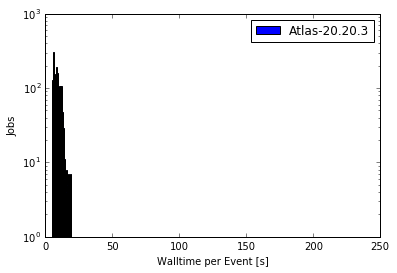

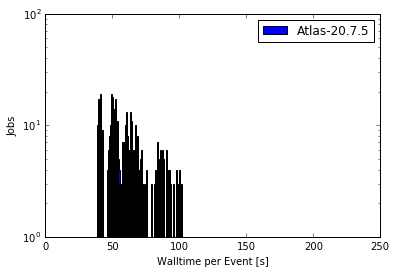

In [91]:
hists = [[],[],[],[]]
xbins = []
rels = ['Atlas-20.11.0', 'Atlas-20.1.5', 'Atlas-20.20.3', 'Atlas-20.7.5']

j = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']/10
    xbins.append(x)
    for hist in hists:
        hist.append(0)
    for e in r['3']['buckets']:
        i = 0
        for rel in rels:
            if e['key'] == rels[i]:
                hists[i][j] = e['doc_count']
            i = i + 1
    j = j + 1

#print(hists)
#print(len(xbins),len(hists[3]))
i = 0
for hist in hists:
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins,hist, log=True, label=rels[i])
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    i = i + 1
    plt.xlabel('Walltime per Event [s]')
    plt.ylabel('Jobs')

    plt.legend(loc='upper right')
    plt.show()